In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
data_path = "features.csv"
audio_data = pd.read_csv(data_path)

from google.colab import drive
drive.mount('/content/drive')

In [3]:
label_encoder = LabelEncoder()
audio_data['label'] = label_encoder.fit_transform(audio_data['label'])

audio_data.head()

,chroma_stft,rms,spectral_centroid,spectral_rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.599570,0.018825,2474.435463,4653.320312,0.235852,-316.533386,56.304161,-20.794659,7.109140,-11.212868,...,-2.426385,-10.777628,-1.015582,-3.867706,0.069288,-8.353317,1.757127,-3.021266,2.430824,1
1,0.381150,0.045605,1227.258319,2252.750000,0.073797,-277.394318,128.666290,2.184755,21.328552,0.444204,...,-3.950951,-11.978324,-0.950092,-7.959801,8.930393,-8.709599,1.849423,-2.804388,-2.806101,1
2,0.335554,0.016387,1756.447754,3214.843750,0.147343,-409.048492,79.631767,-41.807468,95.019081,-3.043697,...,10.275462,-0.963025,2.854904,-11.380973,-2.175731,1.971693,-5.873505,7.578308,2.709637,0
3,0.359864,0.024853,1178.562275,2143.286401,0.078570,-405.704529,111.235405,-2.054637,7.267512,-1.017351,...,-3.926135,-8.767957,-7.036883,-4.038278,-7.176916,-9.072795,-2.882145,-8.041457,-8.224609,1
4,0.322562,0.029143,1545.583859,2703.247453,0.130057,-376.272034,92.828758,-16.043211,33.448944,-12.320236,...,-2.360322,-11.998015,2.283856,-16.257866,-2.338769,-7.670524,-5.738888,-4.679354,-4.195476,0


In [4]:
y = audio_data['label']
X = audio_data.drop('label', axis = 1)

In [5]:
X.columns

Index(['chroma_stft', 'rms', 'spectral_centroid', 'spectral_rolloff',
       'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
       'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19',
       'mfcc20'],
      dtype='object')

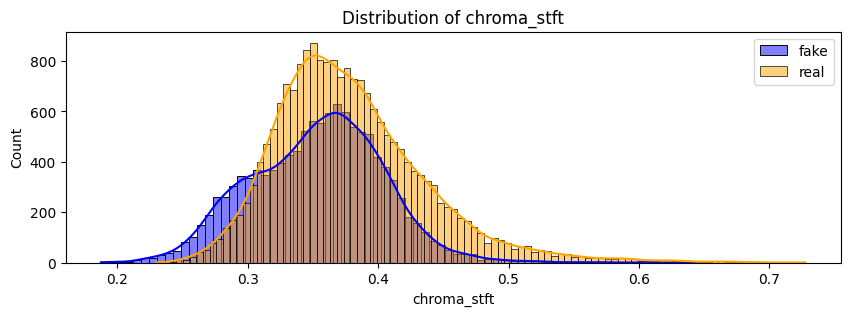

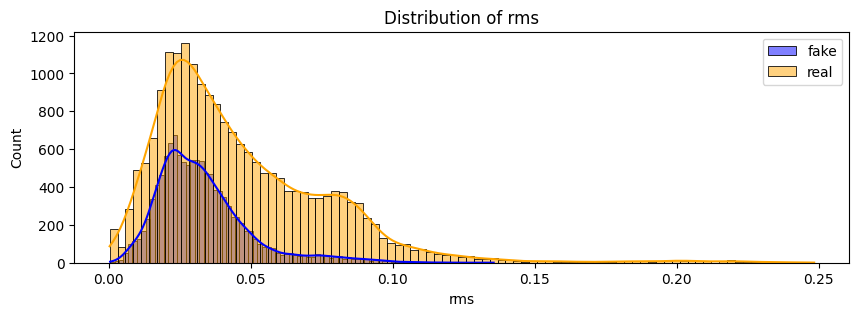

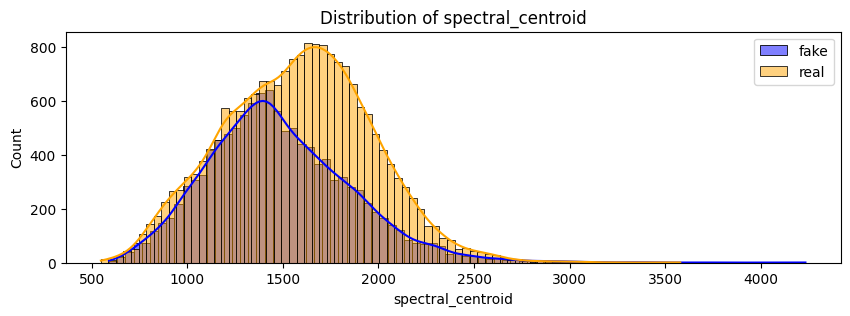

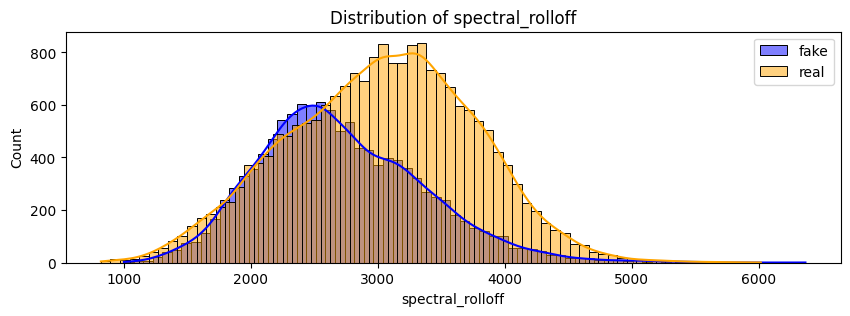

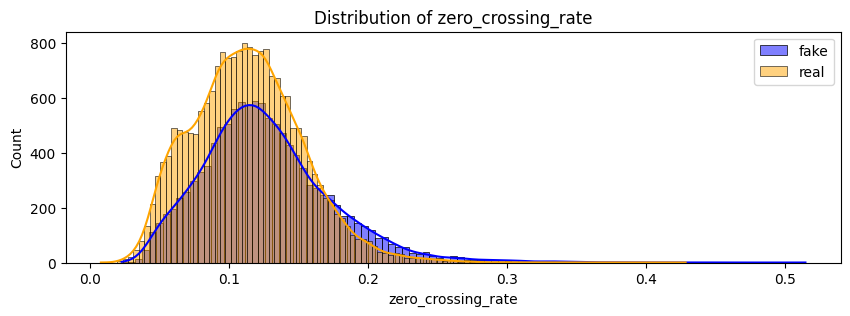

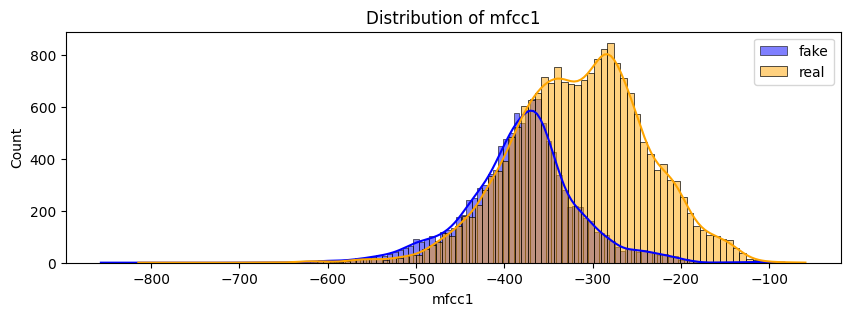

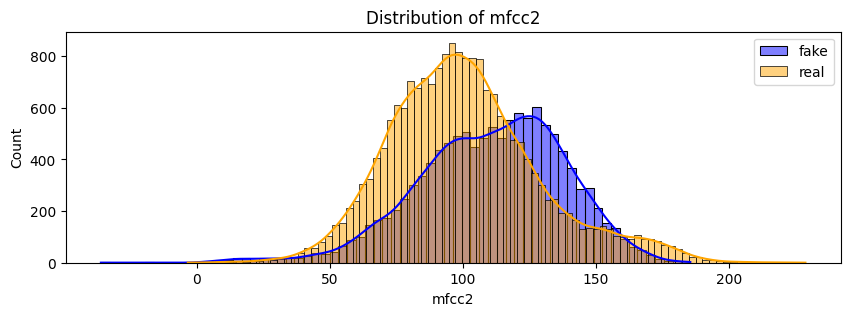

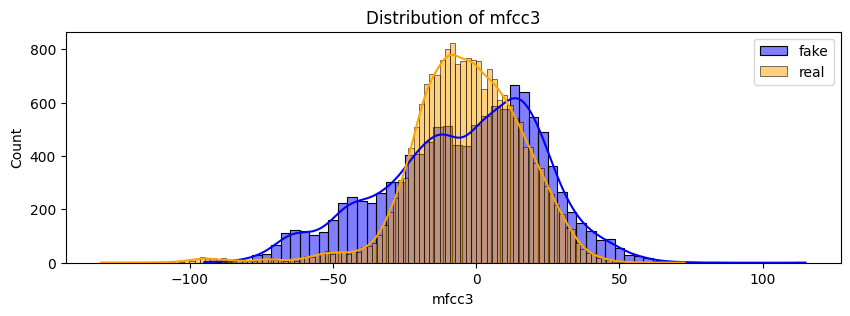

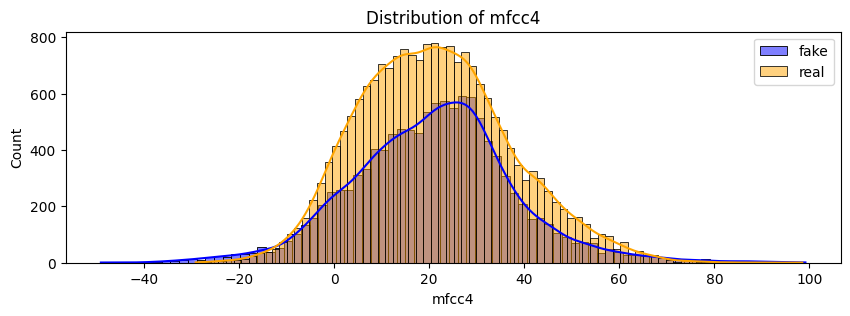

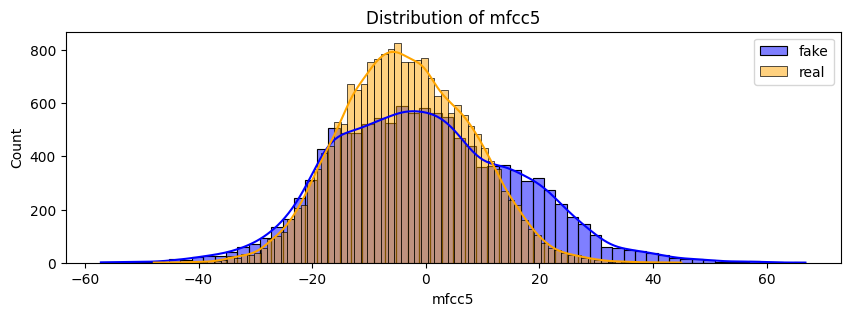

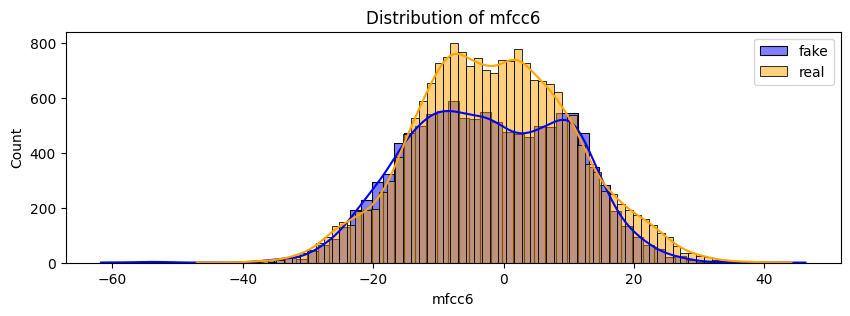

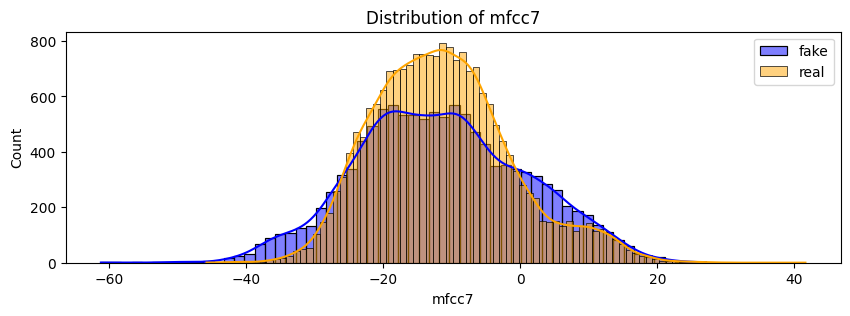

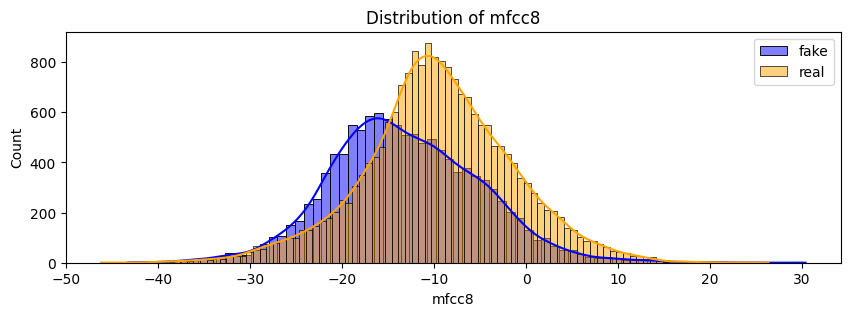

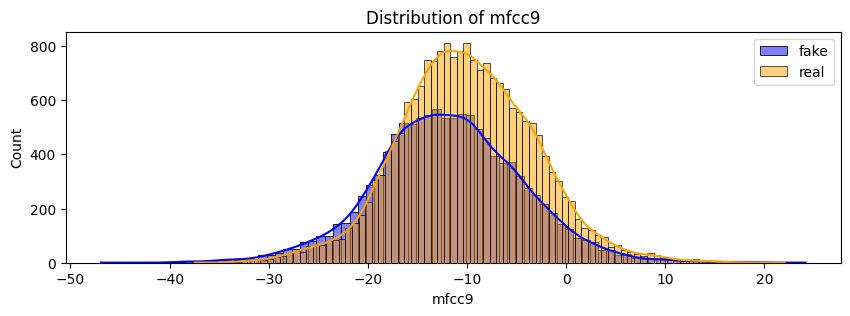

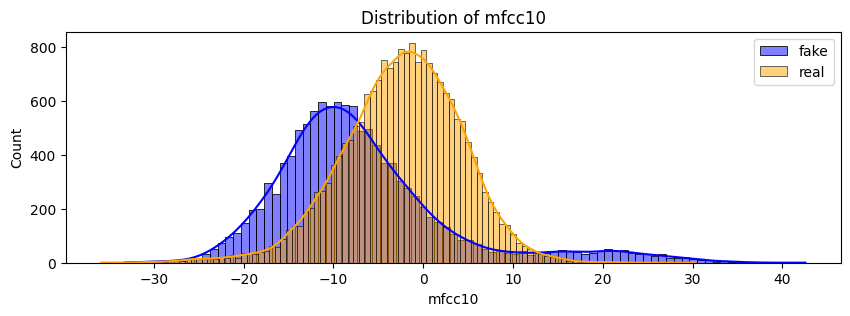

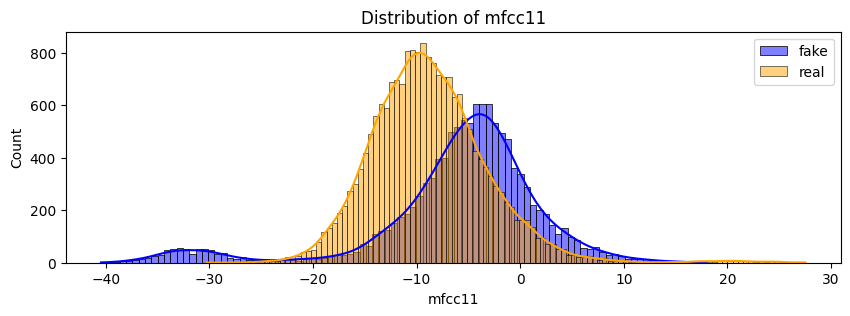

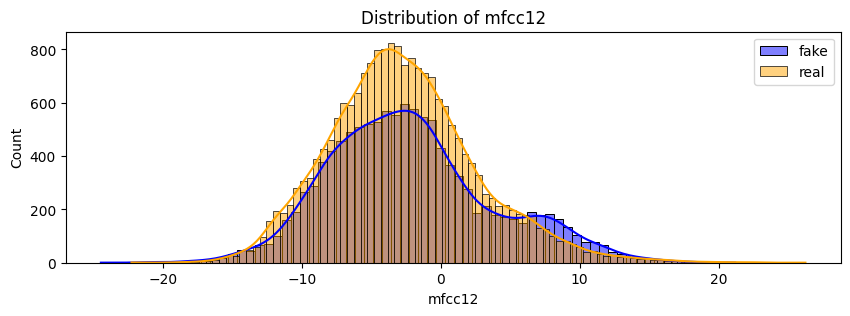

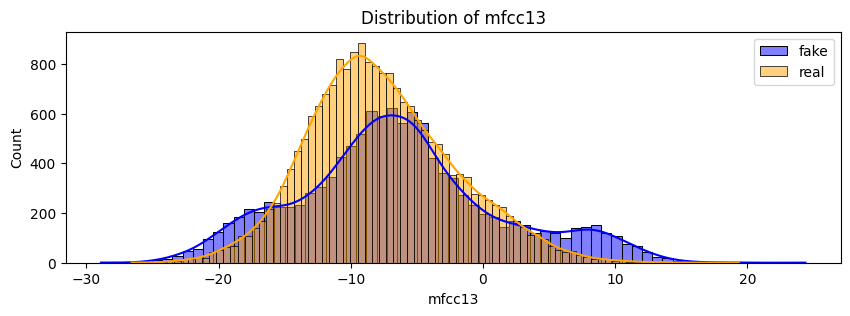

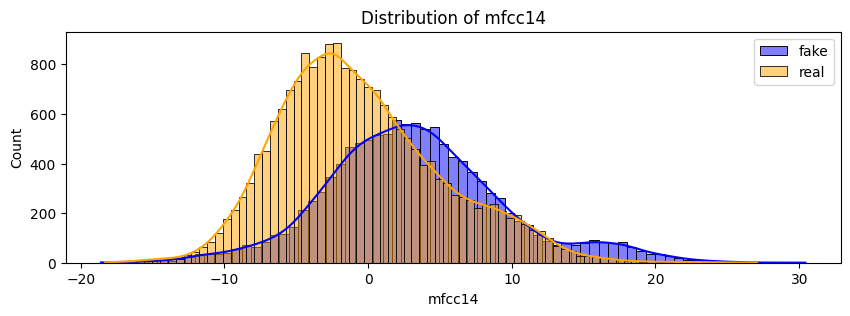

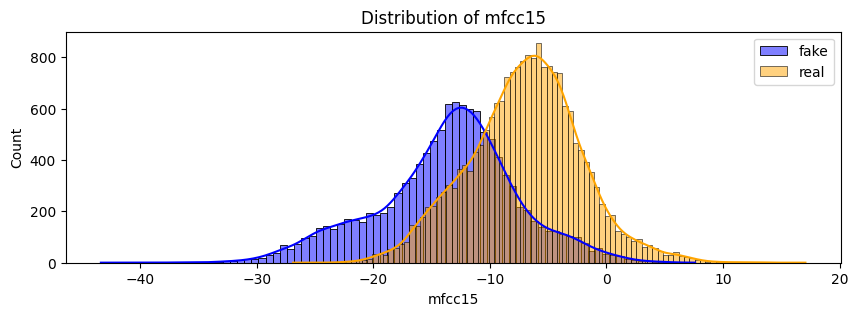

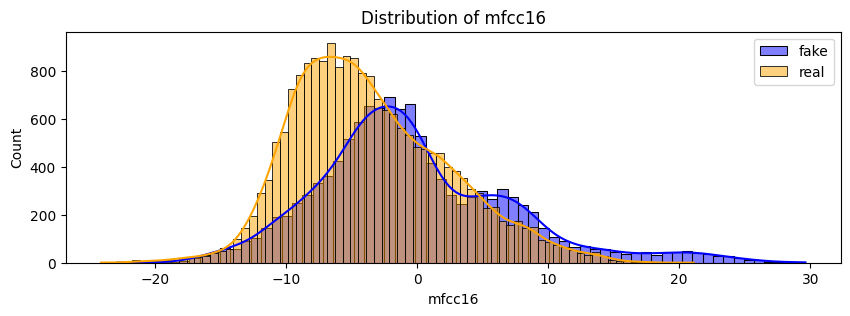

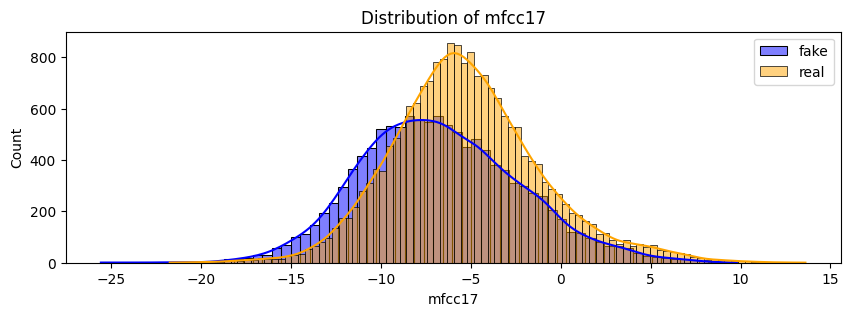

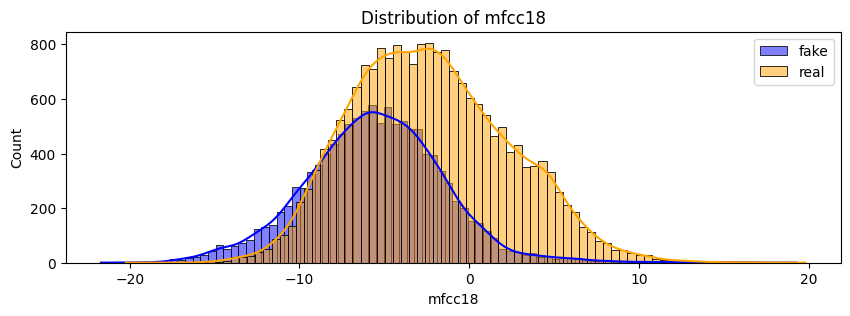

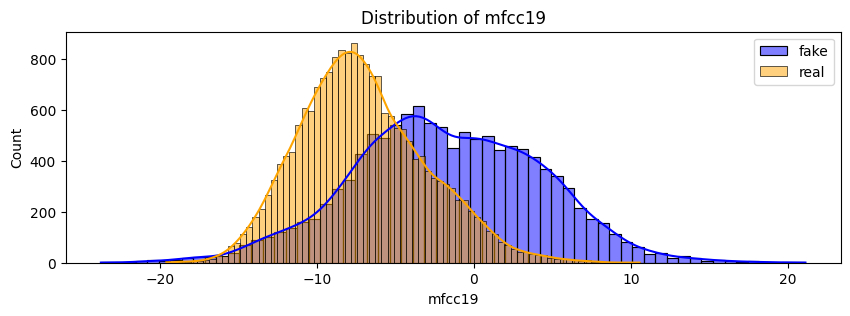

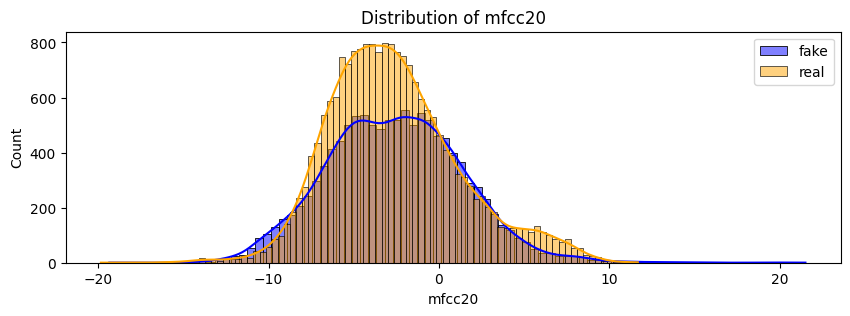

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
for column in X:
    plt.figure(figsize=(10, 3))
    sns.histplot(audio_data[audio_data['label'] == 0][column], kde=True, label='fake', color='blue')
    sns.histplot(audio_data[audio_data['label'] == 1][column], kde=True, label='real', color='orange')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

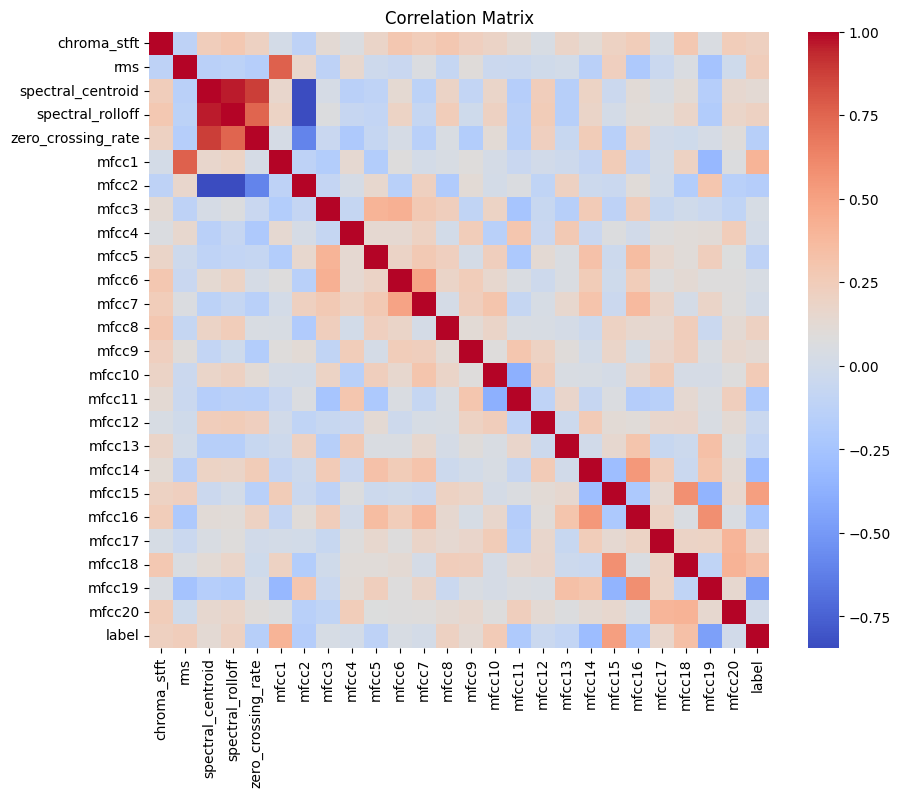

In [7]:
import seaborn as sns

correlation_matrix = audio_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# LSTM

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True ,random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)

(25423, 25)
(6356, 25)


In [10]:
target_columns = 17 * 10


if X_train.shape[1] < target_columns:
    padding_train = np.zeros((X_train.shape[0], target_columns - X_train.shape[1]))
    X_train_padded = np.hstack([X_train, padding_train])
else:
    X_train_padded = X_train[:, :target_columns]

X_reshaped = X_train_padded.reshape(X_train.shape[0], 17, 10)


y_reshaped = np.reshape(y_train.values, (y_train.shape[0], 1))


X_train = X_reshaped
y_train = y_reshaped


In [11]:
if X_test.shape[1] < target_columns:
    padding_test = np.zeros((X_test.shape[0], target_columns - X_test.shape[1]))
    X_test_padded = np.hstack([X_test, padding_test])
else:
    X_test_padded = X_test[:, :target_columns]

X_test_reshaped = X_test_padded.reshape(X_test.shape[0], 17, 10)


y_test_reshaped = np.reshape(y_test.values, (y_test.shape[0], 1))


X_test = X_test_reshaped
y_test = y_test_reshaped

In [12]:
print(X_train.shape)
print(y_train.shape)

(25423, 17, 10)
(25423, 1)


In [13]:
model = Sequential()

model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(64))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

C:\Users\saura\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 17, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,497 (228.50 KB)

 Trainable params: 58,497 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.7404 - loss: 0.5171
Epoch 2/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9425 - loss: 0.1951
Epoch 3/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9526 - loss: 0.1623
Epoch 4/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9587 - loss: 0.1361
Epoch 5/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9615 - loss: 0.1179
Epoch 6/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9683 - loss: 0.1026
Epoch 7/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9691 - loss: 0.0961
Epoch 8/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9688 - loss: 0.0929
Epoch 9/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9722 - loss: 0.0839
Epoch 10/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9709 - loss: 0.0844
Epoch 11/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9739 - loss: 0.0787
Epoch 12/20
795/795 ━━━━━━━━━━

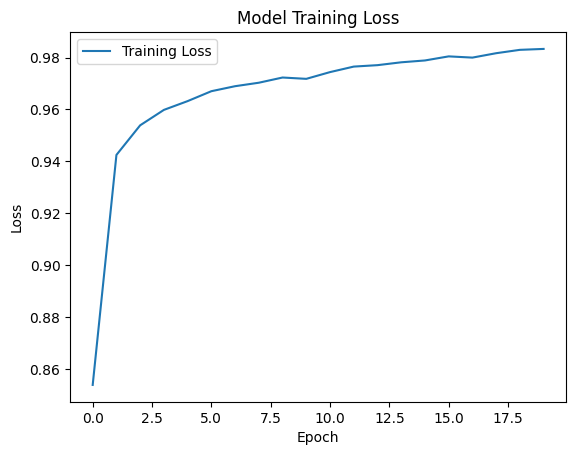

In [14]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20)

plt.plot(history.history['accuracy'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss'])
plt.show()


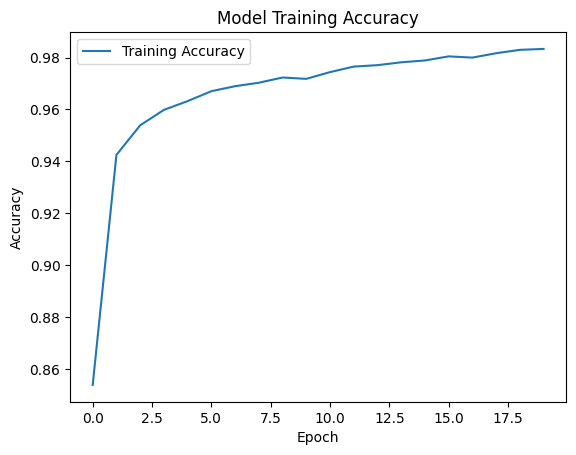

In [15]:
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy'])
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9715 - loss: 0.1054
Test Loss: 0.08733312785625458
Test Accuracy: 0.9743549227714539


In [20]:
# Import necessary libraries
from tensorflow.keras.models import save_model
import os
# Mount Google Drive if not already mounted
# drive.mount('/content/drive')

# Create a directory to save models if it doesn't exist
save_path = 'models'
os.makedirs(save_path, exist_ok=True)

# After training the LSTM model
def save_lstm_model(model, history):
    # Save the model
    lstm_model_path = os.path.join(save_path, 'lstm_model.keras')
    save_model(model, lstm_model_path)

    # Save training history
    import json
    history_path = os.path.join(save_path, 'lstm_history.json')
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

    print(f"LSTM Model saved to: {lstm_model_path}")
    print(f"Training history saved to: {history_path}")


# For LSTM model, add this after the training:
# Save LSTM model and its history
save_lstm_model(model, history)

# For WireNet model, modify the training code slightly to capture history:
# Modify the model.fit() call to capture history:

def load_saved_models():
    from tensorflow.keras.models import load_model

    lstm_model_path = os.path.join(save_path, 'lstm_model.keras')

    lstm_model = load_model(lstm_model_path)

    return lstm_model

LSTM Model saved to: models\lstm_model.keras
Training history saved to: models\lstm_history.json
